Using TensorFlow backend.


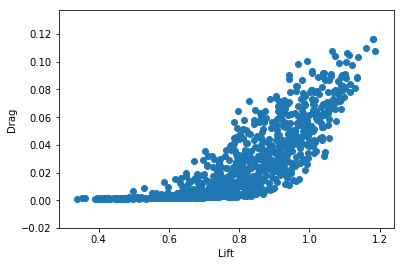

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt



import numpy as np

qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))

plt.scatter(forces[:,1], forces[:,2])
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.show()

N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]

permuted_indices = range(N)#np.random.permutation(N)
qmc_points=qmc_points[permuted_indices,:]
forces = forces[permuted_indices,:]
input_size=6
force_component = 1
train_size=128
validation_size=200



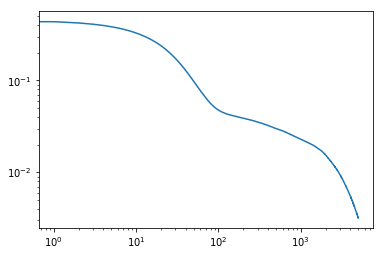

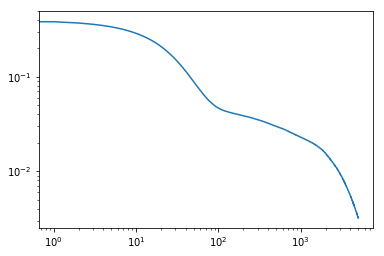

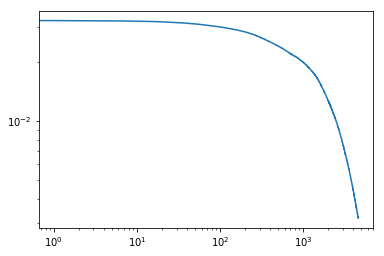

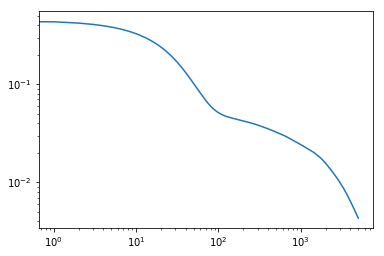

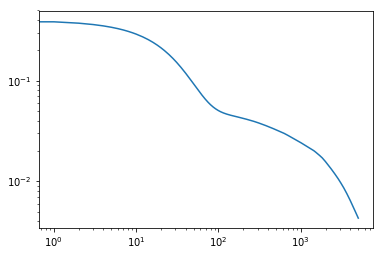

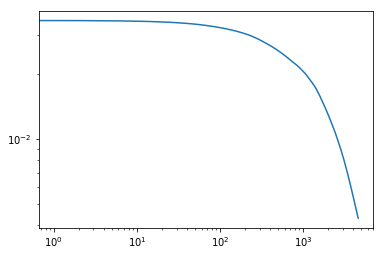

Text(0,0.5,'Predicted data')

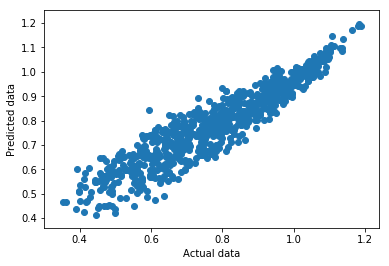

In [3]:
model = Sequential([
    Dense(5, input_shape=(input_size,)),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(5),
    Activation('relu'),
    Dense(1)
])
model.compile(optimizer=keras.optimizers.SGD(lr=0.001),
              loss='mean_squared_error')
x_train = qmc_points[:train_size,:]
y_train=forces[:train_size,force_component]


x_val = qmc_points[train_size:validation_size+train_size,:]
y_val=forces[train_size:train_size+validation_size,force_component]
epochs=5000

hist = model.fit(x_train, y_train,
          batch_size=train_size//4, epochs=epochs,shuffle=True,
          validation_data=(x_val, y_val),verbose=0)

epochs_r=range(1, epochs)
plt.loglog(hist.history['loss'])
plt.show()
plt.loglog(hist.history['loss'][4:])
plt.show()
plt.loglog(hist.history['loss'][400:])
plt.show()
plt.loglog(hist.history['val_loss'])
plt.show()
plt.loglog(hist.history['val_loss'][4:])
plt.show()
plt.loglog(hist.history['val_loss'][400:])
plt.show()
x_test =  qmc_points[validation_size+train_size:,:]
y_test = forces[train_size+validation_size:,force_component]
y_predict = model.predict(x_test)
plt.scatter(y_test, y_predict)
plt.xlabel("Actual data")
plt.ylabel("Predicted data")

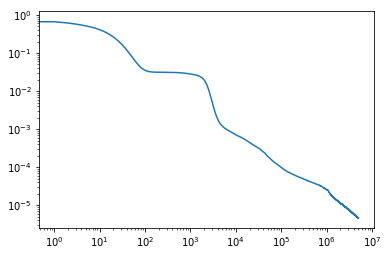

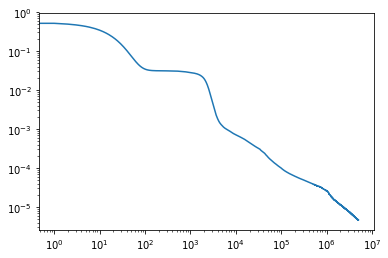

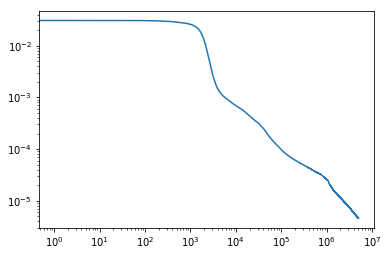

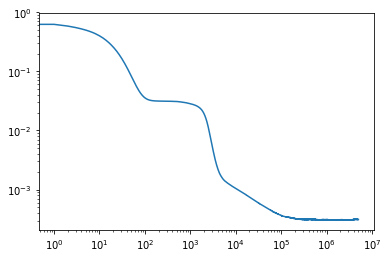

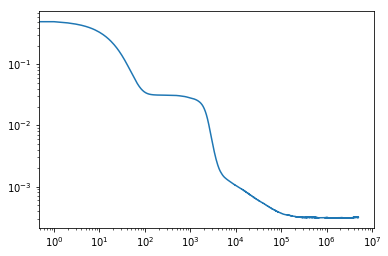

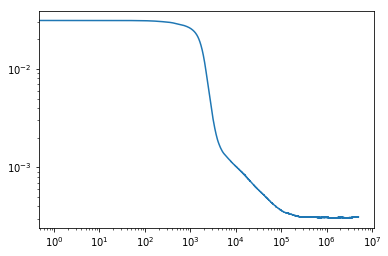

Text(0,0.5,'Predicted data')

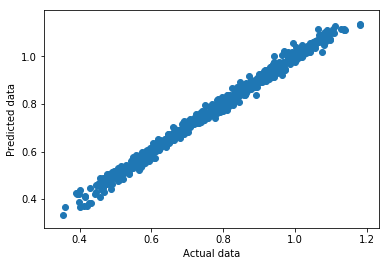

In [8]:
model = Sequential([
    Dense(10, input_shape=(input_size,)),
    Activation('relu'),
    Dense(12),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(12),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(1)
])
model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
              loss='mean_squared_error')
x_train = qmc_points[:train_size,:]
y_train=forces[:train_size,force_component]


x_val = qmc_points[train_size:validation_size+train_size,:]
y_val=forces[train_size:train_size+validation_size,force_component]
epochs=5000000

hist = model.fit(x_train, y_train,
          batch_size=train_size, epochs=epochs,shuffle=True,
          validation_data=(x_val, y_val),verbose=0)

epochs_r=range(1, epochs)
plt.loglog(hist.history['loss'])
plt.show()
plt.loglog(hist.history['loss'][4:])
plt.show()
plt.loglog(hist.history['loss'][400:])
plt.show()
plt.loglog(hist.history['val_loss'])
plt.show()
plt.loglog(hist.history['val_loss'][4:])
plt.show()
plt.loglog(hist.history['val_loss'][400:])
plt.show()
x_test =  qmc_points[validation_size+train_size:,:]
y_test = forces[train_size+validation_size:,force_component]
y_predict = model.predict(x_test)
plt.scatter(y_test, y_predict)
plt.xlabel("Actual data")
plt.ylabel("Predicted data")

(1001,)
(673,)


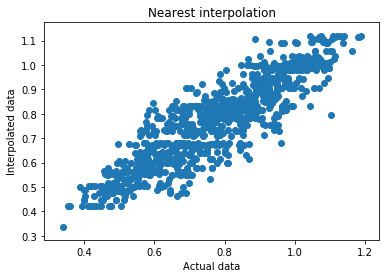

Text(0,0.5,'Interpolated data')

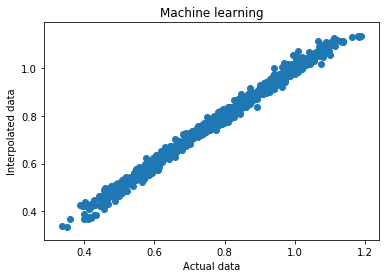

In [10]:
import scipy.interpolate
interpolated = scipy.interpolate.griddata(qmc_points[:train_size,:], y_train, qmc_points, method='nearest')
interpolated[np.isnan(interpolated)] = 2
print(interpolated.shape)
print(y_test.shape)
plt.scatter(forces[:,force_component], interpolated)
plt.title("Nearest interpolation")
plt.xlabel("Actual data")
plt.ylabel("Interpolated data")
plt.show()

plt.scatter(forces[:,force_component], model.predict(qmc_points))
plt.title("Machine learning")

plt.xlabel("Actual data")
plt.ylabel("Interpolated data")

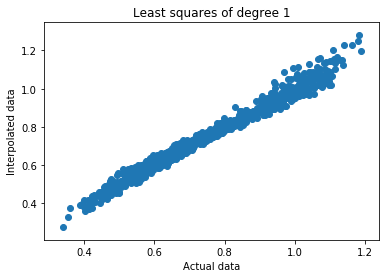

In [13]:
polyfit_degrees = [1,2,3,4]
from sklearn import linear_model
reg = linear_model.LinearRegression()
coeffs = reg.fit(qmc_points[:train_size,:], y_train)

evaluated_lsq = coeffs.predict(qmc_points)
plt.scatter(forces[:,force_component], evaluated_lsq)
plt.title('Least squares of degree 1')
plt.xlabel("Actual data")
plt.ylabel("Interpolated data")
plt.show()

# Doing MLMLMC (machine learning multi level monte carlo)

In [14]:
def myvar(x):
    mean = np.sum(x)/x.shape[0]
    var = np.sum((mean-x)**2)/x.shape[0]
    return var
    
def mymean (x): 
    return np.sum(x)/x.shape[0]

variance_top = myvar(forces[:, force_component])
print("variance single level = %f" % variance_top)
predicted = model.predict(qmc_points)
predicted = predicted.reshape(qmc_points.shape[0])
variance_diff_ml = myvar(forces[:, force_component] - predicted)


print("variance diff ml = %f " % variance_diff_ml)
print("speedup = %f" % (variance_top/variance_diff_ml/2.))
print((forces[:, force_component] - evaluated_lsq).shape)
variance_diff_interpolate =myvar(forces[:, force_component] - evaluated_lsq)
print("variance_diff_interpolate = %f" % variance_diff_interpolate)

mean_qmc = np.mean(forces[:,force_component])
print("mean_qmc = %f" % mean_qmc)
mean_ml = np.mean(model.predict(qmc_points))
print("mean_ml = %f" % mean_ml)
mean_few_qmc = np.mean(qmc_points[:train_size,:])

print("mean_few_qmc = %f" % mean_few_qmc)
predicted_all = model.predict(all_points)
predicted_all = predicted_all.reshape(all_points.shape[0])
print(predicted_all.shape)
mean_mlmlmc = mymean(predicted[:train_size]-forces[:train_size,force_component]) + mymean(predicted_all)

print("mean_mlmlmc = %f" % mean_mlmlmc)
var_qmc = np.var(forces[:,force_component])
print("var_qmc = %f" % var_qmc)
var_ml = np.var(model.predict(qmc_points))
print("var_ml = %f" % var_ml)
var_few_qmc = np.var(qmc_points[:train_size,:])

print("var_few_qmc = %f" % var_few_qmc)
print(qmc_points.shape)





variance single level = 0.031350
variance diff ml = 0.000264 
speedup = 59.355558
(1001,)
variance_diff_interpolate = 0.000684
mean_qmc = 0.770562
mean_ml = 0.771540
mean_few_qmc = 0.496094
(8000,)
mean_mlmlmc = 0.772132
var_qmc = 0.031350
var_ml = 0.031332
var_few_qmc = 0.083328
(1001, 6)


In [28]:
%%timeit 
evaluated = model.predict(qmc_points)

27 ms ± 977 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
